In [0]:
import numpy as np
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Model,model_from_json
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras


In [0]:
np.random.seed(3)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        k = len(self.losses)
        if(k!=0):
            self.losses.append((logs.get('loss')+self.losses[k-1]*k)/(k+1))
        else:
            self.losses.append(logs.get('loss'))


DATA_DIR = "/content/drive/DL/small"

In [7]:
train_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"train",target_size=(224,224),color_mode='rgb',
                                                         classes=["AK","FR","Noise","SGV", "SK","SM", "SP"],class_mode="categorical", batch_size=32)

Found 14387 images belonging to 7 classes.


In [8]:
val_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"val",target_size=(224,224),color_mode='rgb',
                                                       classes=["AK","FR","Noise","SGV", "SK","SM", "SP"], class_mode="categorical",batch_size=32)
test_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"test",target_size=(224,224),color_mode='rgb',
                                                        classes=["AK","FR","Noise","SGV", "SK","SM", "SP"], class_mode="categorical",batch_size=32)

Found 1780 images belonging to 7 classes.
Found 1811 images belonging to 7 classes.


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


94658560/94653016 [==============================] - 1s 0us/step


In [10]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')
history = LossHistory()



loss_acc = model.fit_generator(generator=train_datagen,validation_data=val_datagen,epochs=5,callbacks=[history])

Epoch 1/5
450/450 [==============================] - 7026s 16s/step - loss: 0.2220 - acc: 0.9485 - val_loss: 1.7216 - val_acc: 0.7747
Epoch 2/5
258/450 [================>.............] - ETA: 3:14 - loss: 0.0720 - acc: 0.9827450/450 [==============================] - 480s 1s/step - loss: 0.0776 - acc: 0.9820 - val_loss: 0.1711 - val_acc: 0.9556
Epoch 3/5
395/450 [=========================>....] - ETA: 56s - loss: 0.1281 - acc: 0.9684450/450 [==============================] - 486s 1s/step - loss: 0.1231 - acc: 0.9697 - val_loss: 0.3781 - val_acc: 0.9326
Epoch 4/5
447/450 [============================>.] - ETA: 3s - loss: 0.0486 - acc: 0.9880450/450 [==============================] - 485s 1s/step - loss: 0.0485 - acc: 0.9880 - val_loss: 0.5272 - val_acc: 0.8708
Epoch 5/5
450/450 [==============================] - 487s 1s/step - loss: 0.0451 - acc: 0.9890 - val_loss: 0.0170 - val_acc: 0.9927


In [12]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
model_json = model.to_json()
with open("/content/drive/DL/model_resnet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/DL/model_resnet.h5")
print("Saved model to disk")


Saved model to disk


In [14]:
json_file = open('/content/drive/DL/model_resnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/DL/model_resnet.h5")
print("Loaded model from disk")


loaded_model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')

preds = loaded_model.evaluate_generator(test_datagen)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loaded model from disk
Loss = 0.023641265961802466
Test Accuracy = 0.9950303699613473


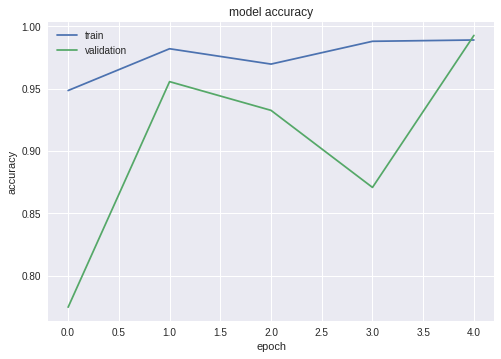

In [15]:
# summarize history for accuracy
plt.plot(loss_acc.history['acc'])
plt.plot(loss_acc.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

<function matplotlib.pyplot.show>

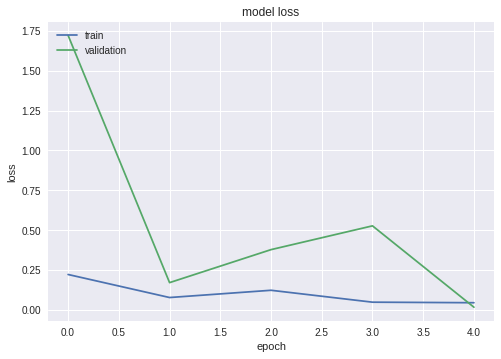

In [16]:
plt.plot(loss_acc.history['loss'])
plt.plot(loss_acc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show


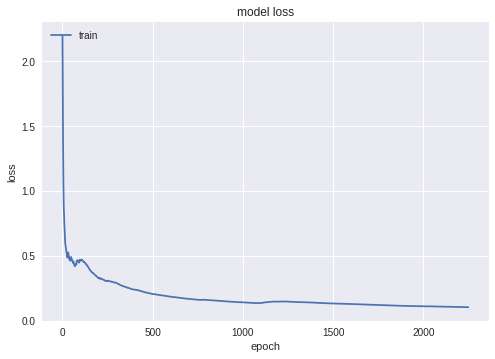

In [17]:
plt.plot(history.losses)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()